In [5]:
# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'

import cv2
import numpy as np
import pandas as pd
import random
import pickle
from PIL import Image
from os.path import isfile
from IPython.display import Image, display
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
consolidated_result = None

with Path('consolidated_result.dmp').open(mode = 'rb') as handle:
    consolidated_result = pickle.load(handle)

dict_keys([(0, 'loss'), (0, 'acc'), (1, 'loss'), (1, 'acc'), (0, 'accuracy')])


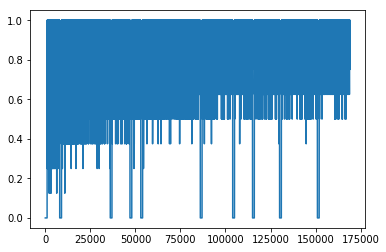

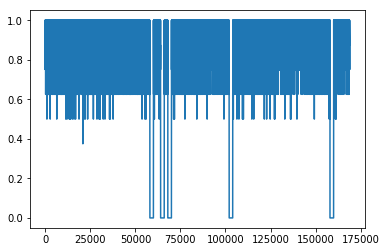

In [14]:
print(consolidated_result.keys())

plt.plot(consolidated_result[0, 'acc'])

plt.figure()
plt.plot(consolidated_result[1, 'acc'])

In [5]:
from client.dropbox import DropboxConnection
from enum import Enum

#Input source enums
class InputSourceOptions(Enum):
  REBALANCED_DATA = 0
  DOWNLOAD = 1
  NONE = 2
  
class ModelOptions(Enum):
  GENERATE = 0
  DOWNLOAD = 1
  NONE = 2
  
class PredictionSourceOptions(Enum):
  GENERATE = 0
  DOWNLOAD = 1
  NONE = 2

#Global parameters
remote_store = 'densenet_trial'
input_data_file = 'input_data.batch.0.epoch.0.csv'
rebalanced_input_data_file = 'rebalanced_input_data_512.csv'
prediction_input_data_file = 'prediction_input_data.batch.0.epoch.0.csv'
augmented_input_data_file = 'augmented_input_data_512.csv'
model_file = 'siamese_network_mobilenet.batch.0.epoch.0.h5'
input_data_source = InputSourceOptions.REBALANCED_DATA
model_option = ModelOptions.GENERATE
prediction_option = PredictionSourceOptions.GENERATE

#Dropbox connection parameters
params = DropboxConnection.Parameters('RJNtqAmFFEgAAAAAAAG0Gtn39Pq66F8FFa9248CmepaGrLpvEcEo3XVeX3AiYmPH', remote_store)

#Dropbox client
client = DropboxConnection(params)

In [7]:
%load_ext autoreload
%autoreload 2

from common.pandas import *

if prediction_option == PredictionSourceOptions.GENERATE:
  #Download augmented data
  client.download(augmented_input_data_file)
  
  #Download rebalanced data
  client.download(rebalanced_input_data_file)
  
  #Load data files
  augmented_input_data = csv_to_dataframe(augmented_input_data_file)
  rebalanced_input_data = csv_to_dataframe(rebalanced_input_data_file)
  
  #Pull the images in the rebalanced data
  images_in_rebalanced_data = unique_items(rebalanced_input_data, 'Image')
  
  #Prediction data frame
  untrained_input_data = remove(augmented_input_data, 'Image', images_in_rebalanced_data)
  untrained_input_data.to_csv('untrained_input_data.csv')
  
  #Initialize siamese network tuples
  !python siamese_input_tuples.py -i untrained_input_data.csv -o prediction_input_data.batch.0.epoch.0.csv -c Image Id --output_cols Anchor Sample Label -s 10 -n 2000 -f
  
  #Upload the prediction data data
  client.upload(prediction_input_data_file)
elif prediction_option == PredictionSourceOptions.DOWNLOAD:
  #Download prediction data
  client.download(prediction_input_data_file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Downloading: /run_data/densenet_trial/augmented_input_data_512.csv: 100%|██████████| 22916688/22916688 [00:04<00:00, 6166509.09it/s]
Downloading: /run_data/densenet_trial/rebalanced_input_data_512.csv: 100%|██████████| 4433574/4433574 [00:00<00:00, 6037034.67it/s]


Generating input tuples: 100%|██████████████| 723/723 [00:00<00:00, 3841.05it/s]

                                    Tuple Generation Summary
                                    Input size: 2000
                                    Output size: 16828
                                    Expected output size: 20000
                                    Error: 3172
                                    


In [4]:
!zip -qr - train | pv -bep -s $(du -bs train | awk '{print $1}') > file.zip

^C40MiB [>                                                     ]  3% ETA 0:09:49



zip error: Interrupted (aborting)
